# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook d'analyse exploratoire</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook d’exploration comprenant une analyse univariée, une analyse multivariée, une réduction dimensionnelle et les différentes questions de recherche associées (non cleané, pour comprendre votre démarche).

## <font color="#114b98">Sommaire</font>
[1. Chargement des jeux de données](#section_1)

[2. Analyse univariée](#section_2)  

[3. Analyse multivariée](#section_3)  

[4. Nettoyage de la colonne 'Tags'](#section_4)  

[5. Nettoyage de la colonne 'Text'](#section_5)  

## <font color="#114b98" id="section_1">1. Chargement des jeux de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline

In [2]:
import lxml
import html5lib
import re
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from typing import List
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.parsing.preprocessing import STOPWORDS
import spacy
spacy.load('en_core_web_sm')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [4]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

J'ai tout d'abord réalisé la requête SQL suivante sur "StackExchange Data Explorer" afin de récuperer les données.
https://data.stackexchange.com/stackoverflow/query/

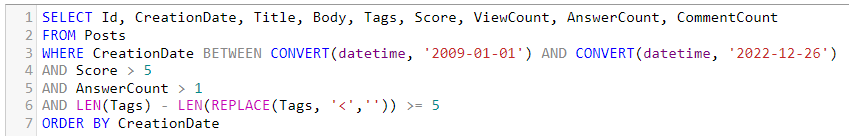

Je recevais 50000 réponses, ce qui est le maximum possible par requête sur ce site.

J'ai donc décidé de réaliser plusieurs requêtes avec des intervalles de temps de deux ans.

In [5]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'ressources/')
files

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'N:/5 - WORK/1 - Projets/Projet 5/ressources/'

Nous avons à notre disposition 7 jeux de données.

Je crée un dictionnaire dans lequel je range les noms des jeux de données en clefs et leurs contenus dans les valeurs.

In [ ]:
%%time
datasets = {}
for i, filename in enumerate(files):
    datasets[i] = pd.read_csv(main_path+'ressources/'+filename, 
                              parse_dates=['CreationDate'],
                              na_values = 'NaN')

In [ ]:
data = pd.DataFrame()

In [ ]:
for n in range(len(datasets)):
    data = pd.concat([data, datasets[n]])

In [ ]:
data.shape

In [ ]:
data.head()

Je crée une nouvelle variable "Text" dans laquelle je joins les données des variables "Titre" et "Body".

In [ ]:
data['Texts'] = data.apply(lambda x: x['Title'] + ' ' + x['Body'] if x['Title'] == x['Title'] else x['Body'], axis=1)

In [ ]:
pd.set_option('display.max_column', 10)

In [ ]:
data.info()

In [ ]:
data.duplicated().sum()

In [ ]:
data.isna().sum()

In [ ]:
data.reset_index(inplace=True, drop=True)

## <font color="#114b98" id="section_2">2. Analyse univariée</font>

In [ ]:
questions_per_day = data['CreationDate'].dt.date.value_counts()

In [ ]:
fig = plt.figure(figsize=(20, 12))
sns.lineplot(data=questions_per_day,
             x=questions_per_day.index,
             y=questions_per_day.values)
plt.xlabel("Date")
plt.ylabel("Nombre de questions")
plt.title("Nombre de questions par jour")

plt.show()

La tendance globale à la baisse est logique. Je me suis limité aux questions qui ont des réponses et un bon score. 

Plus une question est ancienne, plus elle a eu le temps d'être lue, commentée, et de recevoir un score positif si elle le mérite.

In [ ]:
data["CreationDate_year"] = data["CreationDate"].map(lambda y: y.year)

In [ ]:
questions_per_year = data["CreationDate_year"].value_counts()

In [ ]:
fig = plt.figure(figsize=(16, 8))
sns.barplot(x=questions_per_year.index, y=questions_per_year.values)
plt.title("Nombre de questions par année")
plt.xlabel("Année")
plt.xticks(rotation=90)
plt.ylabel("Nombre de questions")
plt.show()

In [ ]:
data["CreationDate_month"] = data["CreationDate"].map(lambda m: m.month)

In [ ]:
fig = plt.figure(figsize=(20, 4))
plt.title('Boxplot des scores',
          titleprops)
sns.boxplot(data=data, x="Score", showfliers=False)

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 4))
plt.title('Boxplot du nombre de vues',
          titleprops)
sns.boxplot(data=data, x="ViewCount", showfliers=False)

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 4))
plt.title('Boxplot du nombre de réponses',
          titleprops)
sns.boxplot(data=data, x="AnswerCount", showfliers=False)

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 4))
plt.title('Boxplot du nombre de commentaires',
          titleprops)
sns.boxplot(data=data, x="CommentCount", showfliers=False)

plt.show()

## <font color="#114b98" id="section_3">3. Analyse multivariée</font>

In [ ]:
corr_matrix = data.corr()
fig = plt.figure(1, figsize=(14, 14))
sns.heatmap(corr_matrix, square=True, linewidths=0.1, annot=True)
plt.xlim(0, corr_matrix.shape[1])
plt.ylim(0, corr_matrix.shape[0])
plt.show()

La corrélation entre le nombre de vues et le score est normale.

Une question bien notée a davantage de chance d'être pertinente et qu'un grand nombre de personne la consulte.

In [ ]:
data.columns

In [ ]:
data.drop(columns=['Id',
                   'CreationDate',
                   'Score',
                   'ViewCount',
                   'AnswerCount',
                   'CommentCount',
                   'CreationDate_year',
                   'CreationDate_month',
                   'Body',
                   'Title'],
          inplace=True)

In [ ]:
print(f"Observations dans le corpus : {data.shape[0]}")

In [ ]:
data.head()

## <font color="#114b98" id="section_4">4. Nettoyage de la colonne 'Tags'</font>

In [ ]:
data['Tags'][0:5]

Les tags sont encadrés par des balises "<" et ">".

In [ ]:
data['Tags'][0][1:-1].split('><')

In [ ]:
data['Tags'] = data['Tags'].apply(lambda row: row[1:-1].split('><'))

In [ ]:
tags = []
for minilist in data['Tags']:
    for item in minilist:
        item = item.lower()
        tags.append(item)

In [ ]:
counts = Counter(tags)

In [ ]:
temp_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
plot_df = temp_df.sort_values('count', ascending=False).head(20)

In [ ]:
fig = plt.figure(figsize=(16, 8))
sns.barplot(x=plot_df.index, y=plot_df['count'])
plt.title("Tags les plus utilisés")
plt.xticks(rotation=90)
plt.ylabel("Nombre d'utilisations")
plt.show()

In [ ]:
wordcloud = WordCloud().generate_from_frequencies(counts)
plt.figure(figsize=[12, 5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
data['Tags'].head()

## <font color="#114b98" id="section_5">5. Nettoyage de la colonne 'Texts'</font>

In [ ]:
# Nettoyage des balises HTML
def clean_html(text):
    soup = BeautifulSoup(text, "html5lib")
    for sent in soup(['style', 'script']):
        sent.decompose()
    return ' '.join(soup.stripped_strings)


# Nettoyage du texte
def clean_text(text):
    pattern = re.compile(r'[^\w]|[\d_]')
    res = re.sub(pattern, " ", text)
    res = " ".join(word for word in res.split() if len(word) >= 3)
    return res


# Tokenisation et retrait des stopwords
nltk_stopwords = set(stopwords.words('english'))
gensim_stopwords = set(STOPWORDS)
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = set(nlp.Defaults.stop_words)
stop_words = nltk_stopwords.union(gensim_stopwords, spacy_stopwords)


def tokenize(text):
    tokens = word_tokenize(text, language='english')
    return [token for token in tokens if token not in stop_words]


# POS Tagging
def filtering_nouns(tokens):
#     res = [token for token, tag in pos_tag(tokens) if tag == 'NN']
    res = [token for token, tag in pos_tag(tokens) if in ['NN', 'NNP']] # IMPORTANT
    return res


# Lemmatisation
def lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [ ]:
data['Texts'][0]

Je passe tout d'abord tous les textes en lettres minuscules.

In [ ]:
data['Texts'] = data['Texts'].str.lower()

In [ ]:
data['Texts'][0]

Le texte comporte des balises HTML que je souhaite effacer.

In [ ]:
data['Texts'] = data['Texts'].apply(clean_html)

In [ ]:
data['Texts'][0]

Je vais conserver uniquement les caractères alphabétiques et supprimer les mots de moins de trois lettres, même si cela va éliminer aussi des informations qui auraient été pertinentes (C, C#, C++, R, ...).

In [ ]:
data['Texts'] = data['Texts'].apply(clean_text)

In [ ]:
data['Texts'][0]

In [ ]:
data['Sentences'] = data['Texts']

Je vais maintenant tokeniser afin de transformer les textes en listes de termes distincts (tokens). 

J'élimine aussi les termes génériques anglais (stop words) afin de n'avoir que des mots pertinents.

In [ ]:
data['Texts'] = data['Texts'].apply(tokenize)

In [ ]:
data['Texts'][0][0:5]

Les mots qui m'interessent le plus sont des noms. Je peux utiliser un modèle de POS tagging basé sur les chaînes de Markov.

In [ ]:
data['Texts'] = data['Texts'].apply(filtering_nouns)

In [ ]:
data['Texts'][0][0:5]

Je vais maintenant lemmatiser, c'est-à-dire identifier la racine sémantique (lemme) des termes et ne conserver que celle-ci afin de ne pas en avoir toutes les déclinaisons des mots.

In [ ]:
data['Texts'] = data['Texts'].apply(lemmatization)

In [ ]:
data['Texts'][0][0:5]

In [ ]:
data.reset_index(inplace=True, drop=True)

In [ ]:
data.head()

In [ ]:
data.info()

Afin de pourvoir comparer lors de mes tests les tags prédits par mes modèles et les tags proposés par les utilisateurs, je décide de filtrer ce jeu de données afin que les tags proposés soient uniquement dans les 5000 premiers tags en terme d'utilisation.

In [ ]:
tags = []
for minilist in data['Tags']:
    for item in minilist:
        tags.append(item)

In [ ]:
counts = Counter(tags)

In [ ]:
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
top_5000 = sorted_counts[:5000]
top_5000_words = [word for word, count in top_5000]

In [ ]:
mask = data['Tags'].apply(lambda x: any(i not in top_5000_words for i in x))

In [ ]:
data = data[~mask]

In [ ]:
data.info()

Je peux maintenant sauvegarder ce jeu de données nettoyé pour la suite du projet.

In [ ]:
data.to_csv(main_path+'saved_ressources/'+"data_cleaned_5000t.csv", index=False)

In [ ]:
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
top_10000 = sorted_counts[:10000]
top_10000_words = [word for word, count in top_10000]
mask = data['Tags'].apply(lambda x: any(i not in top_10000_words for i in x))
data = data[~mask]

In [ ]:
data.to_csv(main_path+'saved_ressources/'+"data_cleaned_10000t.csv", index=False)